In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

def heatmap(title, pixels):
    plt.imshow(pixels, cmap="gray"); plt.colorbar(); plt.grid(visible=False)
    plt.title(title)
    plt.show()

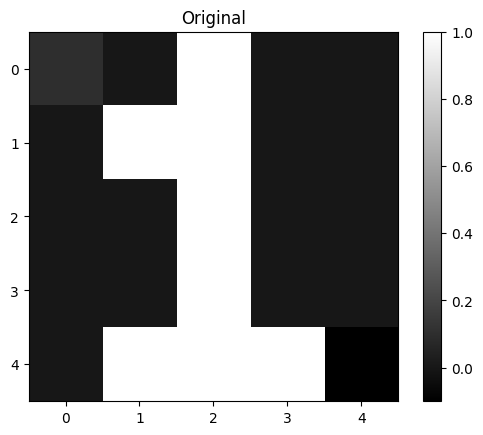

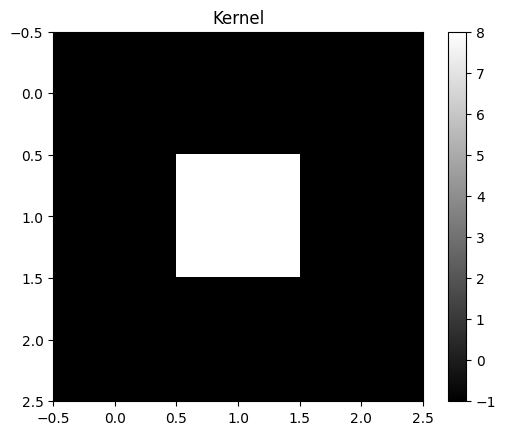

In [4]:
image = np.array([
    [0.1, 0, 1, 0, 0],
    [0, 1, 1, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 1, 1, 1, -0.1],
])

# See what this does at https://www.shadertoy.com/view/XcS3RD
kernel = np.array([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]
])

heatmap("Original", image)
heatmap("Kernel", kernel)

In [5]:
# 1. Caveman convolution

image_height = len(image)
image_width = len(image[0])
kernel_height = len(kernel)
kernel_width = len(kernel[0])

pad_height = (kernel_height - 1) // 2
pad_width = (kernel_width - 1) // 2

# There are a few ways to handle the corners, in this case we are padding the image 
padded_image = [[0] * (image_width + 2 * pad_width) for _ in range(image_height + 2 * pad_height)]
for i in range(image_height):
    for j in range(image_width):
        padded_image[i + pad_height][j + pad_width] = image[i][j]

# glide kernel on the padded image and sum all element-wise products
output = [[0 for _ in range(image_width)] for _ in range(image_height)]
for i in range(image_height):
    for j in range(image_width):
        s = 0
        for ki in range(kernel_height):
            for kj in range(kernel_width):
                s += padded_image[i + ki][j + kj] * kernel[ki][kj]
        output[i][j] = s

# E.g. at the center of the image we have...
# 1 1 0
# 0 1 0
# 0 1 0
# Which gives... -1*1 + -1*1 + -1*0 + -1 * 0 + 8 * 1 + -1 * 0 + -1 * 0 + -1 * 1 + -1 * 0 = 5

output

[[-0.19999999999999996, -3.1, 6.0, -2.0, 0.0],
 [-1.1, 4.9, 5.0, -3.0, 0.0],
 [-1.0, -4.0, 5.0, -3.0, 0.0],
 [-1.0, -4.0, 4.0, -3.9, -0.9],
 [-1.0, 6.0, 5.0, 6.1, -1.8]]

In Fourier analysis, the convolution theorem states:

$F\{f * g\} = F\{f\} \times F\{g\}$

Which allows time domain multiplications, then we get back to the original domain with the inverse FT to get the actual convolution.

$f * g = F^{-1} \{F\{f\} \times F\{g\}\}$

In [ ]:
# Not exact but this is similar in principle with the original matrix kernel
# Smooth 2D Gaussian kernel
def gaussian_kernel(size, sigma, hoffset=0):
    ax = np.linspace(-(size - 1) // 2, (size - 1) // 2, size)
    x, y = np.meshgrid(ax, ax)
    kernel = np.exp(-(x*x+ y*y) / (2 * sigma**2))
    return hoffset + (kernel / np.sum(kernel))
smooth_kernel = gaussian_kernel(size=len(image), sigma=1, hoffset=-1)

td_image = np.fft.fft2(image)
td_kernel = np.fft.fft2(smooth_kernel, s=td_image.shape)
td_conv_as_mult = td_image * td_kernel

fft_ouput = np.fft.ifft2(td_conv_as_mult) # multiplication in time domain
fft_ouput = np.abs(fft_ouput) # for the sake of visualization
fft_ouput

array([[39.64686963, 39.87810321, 39.86303421, 39.62223389, 39.46583897],
       [39.57729   , 39.83253059, 39.81194654, 39.54604977, 39.38829638],
       [39.63463551, 39.8592646 , 39.80268966, 39.53735037, 39.41761396],
       [39.70895318, 39.90352825, 39.82241435, 39.56312206, 39.47141358],
       [39.71861892, 39.91679308, 39.86873859, 39.63153736, 39.51113334]])

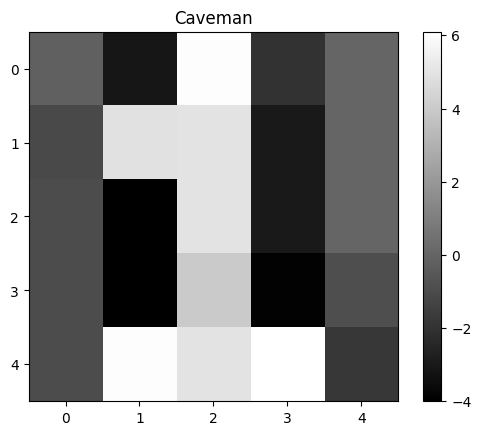

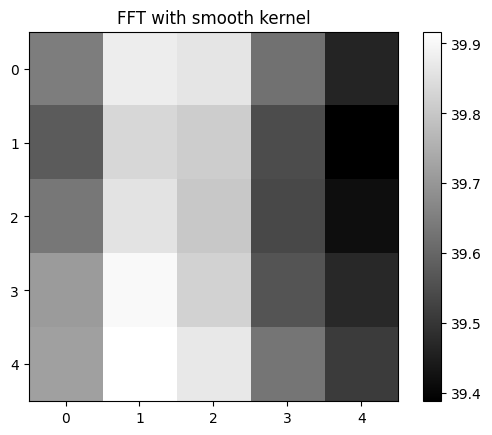

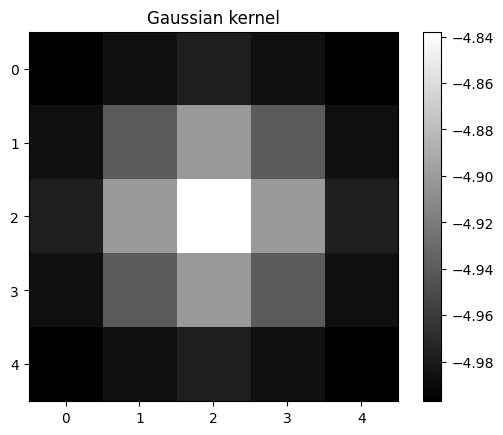

In [12]:
heatmap("Caveman", output)
heatmap("FFT with smooth kernel", fft_ouput)
heatmap("Gaussian kernel", smooth_kernel)